In [207]:
import copy
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy.linalg import inv
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
spam_data = pd.read_csv("../datasets/spam.csv")
spam_label = spam_data["label"].values
spam_features = spam_data.drop(["label"], axis=1).values
spam_data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [112]:
class GaussianNB:
    def __init__(self):
        self.labels = [0, 1]
        self.mean = None
        self.var = None
        self.mask = None
    
    def elem_prob(self, x):
        eps = 0.00001
        lab_prob = np.ones(len(self.labels))
        denom = 0
        for label in range(len(self.labels)):
            pdf = norm(self.mean[label], self.var[label]).pdf(x)
            lab_prob[label] = np.sum(np.log(pdf[self.mask] + eps))
            denom += np.exp(lab_prob[label])
        return np.exp(lab_prob) / denom
    
    def fit(self, X, y):
        self.mean = np.array([np.mean(X[y == label], axis=0) for label in self.labels])
        self.var = np.array([np.var(X[y == label], axis=0) for label in self.labels])
        # filter feature if variance is zero
        self.mask = np.array([True for _ in range(X.shape[1])])
        for i in range(X.shape[1]):
            for label in self.labels:
                if self.var[label, i] == 0.0:
                    self.mask[i] = False
        
    def predict_proba(self, X):
        return np.array([self.elem_prob(x)[1] for x in X])
        
    def predict(self, X):
        y_pr = np.array([self.elem_prob(x) for x in X])
        return np.argmax(y_pr, axis=1)

In [200]:
def gauss_nb(X, y):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8)
    model = GaussianNB()
    model.fit(X_tr, y_tr)
    print(np.mean(model.predict(X_te) == y_te))
    fpr, tpr, thresholds = roc_curve(y_te, model.predict_proba(X_te))
    plt.plot(fpr, tpr)
    plt.show()

0.8805646036916395


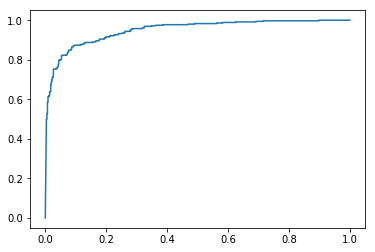

In [201]:
gauss_nb(spam_features, spam_label)

In [135]:
smsspam_data = pd.read_csv("../datasets/smsspam.csv")
smsspam_label = (smsspam_data["label"].values == 'spam') + 0
smsspam_features = (CountVectorizer().fit_transform(np.array([x[0] for x in smsspam_data.drop(["label"], axis=1).values])) != 0) * 1
smsspam_data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [197]:
class MultinomialNB:
    def __init__(self):
        self.labels = [0, 1]
        self.p = None
        self.eps = 1e-6
    
    def elem_prob(self, x):
        lab_prob = np.ones(len(self.labels))
        denom = 0
        for label in range(len(self.labels)):
            xx = x.toarray()
            p = np.multiply(self.p[label].reshape(1, -1), xx) + np.multiply((1 - self.p[label].reshape(1, -1)), (1 - xx))
            lab_prob[label] = np.sum(np.log(p + self.eps))
            denom += np.exp(lab_prob[label])
        return np.exp(lab_prob) / denom
    
    def fit(self, X, y):
        self.p = np.array([np.asarray(np.mean(X[y == label], axis=0))[0] for label in self.labels])
        
    def predict_proba(self, X):
        return np.array([self.elem_prob(x)[1] for x in X])
        
    def predict(self, X):
        y_pr = np.array([self.elem_prob(x) for x in X])
        return np.argmax(y_pr, axis=1)

In [202]:
def multinomial_nb(X, y):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8)
    model = MultinomialNB()
    model.fit(X_tr, y_tr)
    print(np.mean(model.predict(X_te) == y_te))
    fpr, tpr, thresholds = roc_curve(y_te, model.predict_proba(X_te))
    plt.plot(fpr, tpr)
    plt.show()

0.9874439461883409


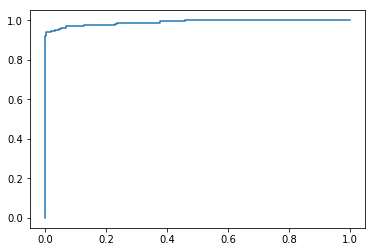

In [203]:
multinomial_nb(smsspam_features, smsspam_label)

In [209]:
noisysine_data = pd.read_csv("../datasets/noisysine.csv")
noisysine_label = noisysine_data["y"]
noisysine_features = noisysine_data.drop(["y"], axis=1)
noisysine_data.head()

,x,y
0,0,0.35552
1,1,0.51179
2,2,1.08470
3,3,0.91980
4,4,1.18920


In [208]:
class LinearRegression:
    def __init__(self):
        self.w = None
        
    def fit(self, X, y, lam=0.0):
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        self.w = inv(X.T @ X + np.eye(X.shape[0]) * lam) @ X.T @ y
        
    def predict(self, X):
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        return X @ self.w

In [ ]:
def add_polinomial(X, deg=2):
    X_p = copy.deepcopy(X)
    for d in range(2, deg + 1):
        for i in range(d + 1):
            X_p[f"x{i}y{d-i}"] = X["x"] ** i * X["y"] ** (d-i)
    return X_p

def r_score(y_true, y_pr):
    (y_pr - y_true)
    return 